## *Capstone Project One*: Iceberg or ship classification, [kaggle Statoil/C-CORE Iceberg Classifier Challenge](https://www.kaggle.com/c/statoil-iceberg-classifier-challenge)
January 2018
Revised Feb. 7th 2018

Author: [Yaqiong Zhang](https://www.linkedin.com/in/yaqiong-zhang-38bba2b4/)

----


## Table of Content
- [1 Introduction](#intro)
   - [1.1 Problem overview](#1.1)
   - [1.2 Set-up AWS EC2 instance](#1.2)
- [2 Analysis](#anal)
   - [2.1 Data import & basic data information ](#2.1)
   - [2.2 Basic image data processing - transfer the image channel  to a 75x75 array](#2.2)
   - [2.3 Plot the image data](#2.3)
   - [2.4 Image argumentation](#2.4)
   - [2.5 EDA with angle data](#2.5)
- [3 Image classification Models](#3)
   - [3.1 Convolutional neural network - basic model](#3.1)
   - [3.2 Convolutional neural network - with manually image rotation](#3.2)
   - [3.3 Convolutional neural network - with ImageDataGenerator from Keras](#3.3)
   - [3.4 Convolutional neural network - with cross validation](#3.4)
   - [3.5 Random forest - feature generated from a convolutional neural network](#3.5)
   - [3.6 Transfer learning - VGG16](#3.6)
- [4 Final notes](#4)
----

<a id= "intro"></a>
## 1 Introduction
<a id= "1.1"></a>
### 1.1 Problem overview

In the movie Titanic, the drifting icebergs were monitored by human eye, which is inefficient and not reliable. Nowadays, people use satellite data to detect drifting icebergs. This is especially useful for the safety of ships or oil stations in a harsh environment. The satellite radar works as bouncing a signal off an object and receive the backscattering signal from the object. The received signal is translated into an image. And in that image we can apply classifiers to detect if there are threaten icebergs in that image area. 

Radar signals contain H and V parts. During the backscattering on an object, the H and V parts will change differently due to the physical propeties of the object. Thus, the change of the two parts contains important information [[1]](http://www.nrcan.gc.ca/node/9567). In this kaggle challenge, dual-polarization image was give with two channels: HH (horizonal transmit and horizontal receive) and HV (horizonal transmit and vertical receive). 

Satillite image is affected by the weather conditions. For example, high wind will generate a brighter background and low wind will generate a darker background. 

Another factor affecting the image is the incidence angle that radar transmit and receive data. The ocean background will be darker at a higher incident angle.

Client of the project would be remote sensing companies like [C-CORE](https://www.c-core.ca/).

<a id= "1.2"></a>
### 1.2 Setup an AWS EC2 instance
Here is steps: [Link](https://yaqiongz.github.io/website/2018/02/05/How-to-setup-an-AWS-EC2-instance.html)

<a id= "anal"></a>
## 2 Analysis
<a id= "2.1"></a>
### 2.1 Data import & basic data information
There are two data files available from this kaggle challenge: train.json and test.json. The test.json contains data without labels. The predicted label will be evaluated in the public Leaderboard which contains 20% of the test data. All the predicted label will be evaluated after the deadline of the challenge (January 23, 2018)

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
#load data
train = pd.read_json("../input/data/processed/train.json")
test = pd.read_json("../input/data/processed/test.json")

In [3]:
#data exploration
train.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


In [4]:
test.tail()

,band_1,band_2,id,inc_angle
8419,"[-25.082357, -26.71583, -24.599827, -25.082571...","[-25.860718, -23.29442, -25.860861, -25.334354...",16ee9b50,34.795500
8420,"[-21.031391143798828, -21.031391143798828, -21...","[-23.755836486816406, -23.755836486816406, -23...",5a599eb7,32.246683
8421,"[-28.609278, -26.514626, -26.514679, -26.83061...","[-28.609278, -29.437183, -30.35239, -31.375494...",df30d6dd,39.503200
8422,"[-27.068821, -27.068892, -23.970854, -22.38730...","[-29.991381, -29.163599, -24.886002, -27.71266...",18af95b1,33.638000
8423,"[-25.438865661621094, -25.438865661621094, -25...","[-23.85527801513672, -23.85527801513672, -23.8...",27d788c8,36.758181


In [5]:
#look at the data types
for idx, feature in enumerate(train.columns):
    print (feature, ": ", train.dtypes[idx])

band_1 :  object
band_2 :  object
id :  object
inc_angle :  object
is_iceberg :  int64


In [6]:
train.describe()

,is_iceberg
count,1604.000000
mean,0.469451
std,0.499222
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


Text(0.5,1,'There are more ships in the training dataset')

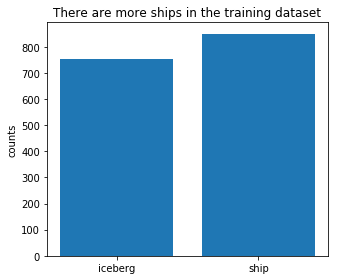

In [59]:
x = ['ship','iceberg']
y = [len(train)-train.is_iceberg.sum(),train.is_iceberg.sum()]
#colors = ['lightcoral', 'lightskyblue']
plt.bar(x,y,width=0.8)
plt.ylabel('counts')
plt.title('Training data: the number of ship images and the number of iceberg images')
plt.tight_layout()
plt.title('There are more ships in the training dataset')

In [10]:
len(train['band_1'][0])

5625

The above results indicate that there are 1604 datasets in this train dataset. There are 8423 data sets in the test dataset. And there are 46.9451% of the images are iceberg imgage in the training dataset.

Band_1 is the HH channel, and band_2 is the HV channel. There are 5625 data point in the image data, which can be convert into a 75x75 array.
<a id= "2.2"></a>
### 2.2 Basic image data processing - transfer the image channel  to a 75x75 array

In [11]:
#process the training data
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)

#process the testing data
X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis],((X_band_test_1+X_band_test_2)/2)[:, :, :, np.newaxis]], axis=-1)

<a id= "2.3"></a>
### 2.3 Plot the image data

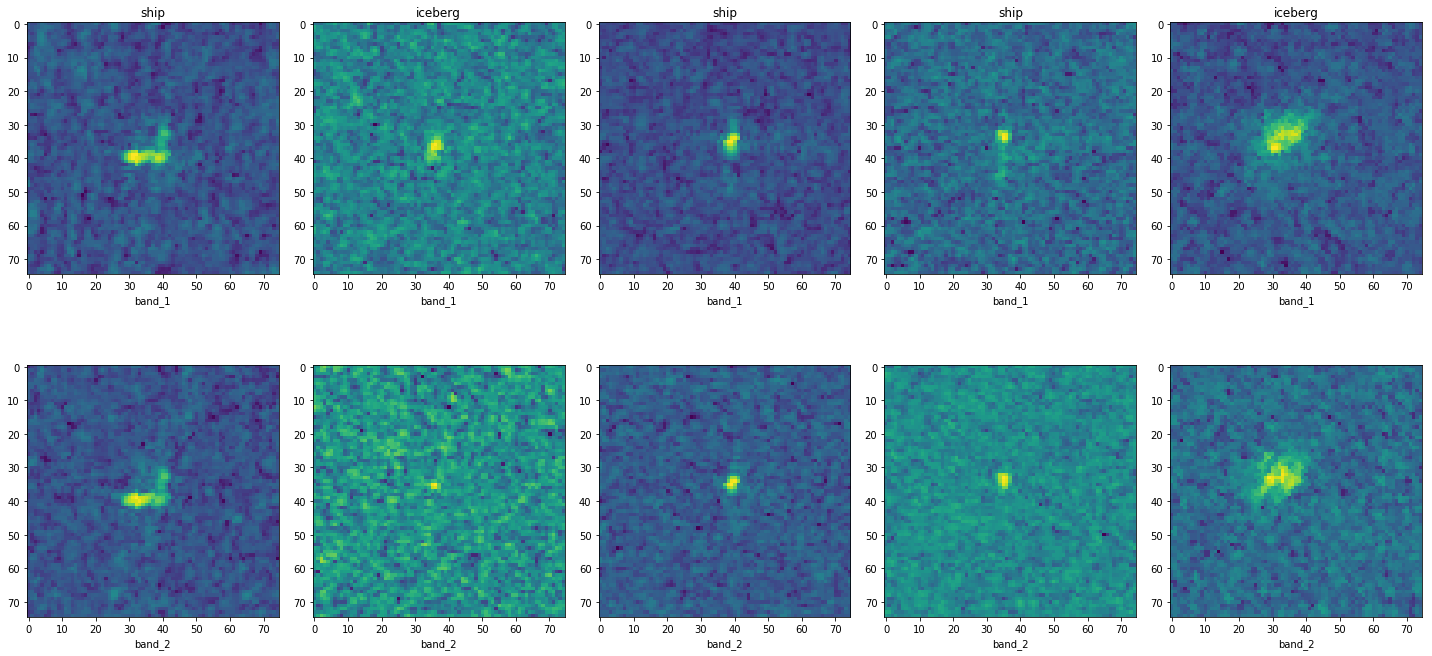

In [12]:
plt.figure(figsize=(20,10))
for example in range(1,6):
   
    plt.subplot(2,5,example)
    plt.imshow(X_band_1[example])
    plt.xlabel('band_1')
    
    if train['is_iceberg'][example] == 1:
        plt.title('iceberg')
    else:
        plt.title('ship')
        
    plt.subplot(2,5,5+example)
    plt.imshow(X_band_2[example])
    plt.xlabel('band_2')

plt.tight_layout()

<a id= "2.4"></a>
### 2.4 Image argumentation
#### Rotate the images 90 degrees and 180 degrees respectively (to increase the amount of training data)
Data argumentation is important when we only have a limit number of training samples and complex model which tends to overfit. Image argumentation is used to generate more images for training purpose. For example, we can rotate the image at certain angle and it still represent the same sample, but the model may be able to learn some new features from the image. Keras have a build-in function for image argumentation: [ImageDataGenerator](https://keras.io/preprocessing/image/). In this section, we shows an example of manually rotate the image to rotate the image 90 degree and 180 degree.

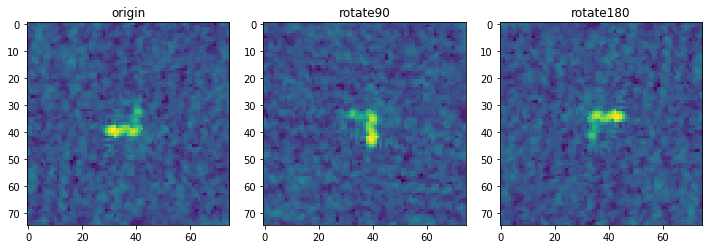

In [13]:
plt.figure(figsize=(10,5))

plt.imshow(X_band_1[1])
plt.subplot(1,3,1)
plt.imshow(X_band_1[1])
plt.title('origin')

X_band_1_rotate90 = np.array([np.rot90(image) for image in X_band_1])
X_band_2_rotate90 = np.array([np.rot90(image) for image in X_band_2])
plt.subplot(1,3,2)
plt.imshow(X_band_1_rotate90[1])
plt.title('rotate90')

X_band_1_rotate180 = np.array([np.rot90(image,2) for image in X_band_1])
X_band_2_rotate180 = np.array([np.rot90(image,2) for image in X_band_2])
plt.subplot(1,3,3)
plt.imshow(X_band_1_rotate180[1])
plt.title('rotate180')

plt.tight_layout()

<a id= "2.5"></a>
### 2.5 EDA with angle data
During this competition, the use angle data was highly debated. Some people claimed that by including the angle data, they were able to improve their model by a certain amount. But later, people talked a lot about the *data leakage* from the angle data, since you can see from the following plotting, a lot of icebergs were measured at the same angle and maybe a clue for finding an iceberg in the testing data. The details of this topic is out the scape of this project, so I didn't dig deep into it.

(30, 35)

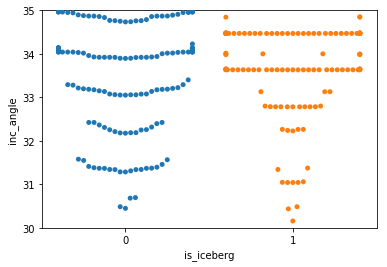

In [28]:
import seaborn as sns
train_clean_angle = train[train.inc_angle != 'na']
sns.swarmplot(x='is_iceberg',y='inc_angle',data = train_clean_angle)
plt.ylim(30,35)

<a id= "3"></a>
## 3 Image classification Models
In this chapter, we will apply and compare the widely used convolutional neural network as well as tree based model, random forest.
<a id= "3.1"></a>
### 3.1 Convolutional neural network - basic model
Image classification or object recognition is a simple and nature thing to human beings, but it's not so easy for computers. The same object may *look* quite different in two photos and it's hard for computer algorithms to learn that. However, since 2010, this field has made tremendous progress using convolutional neural networks (Convnet), and also thanks to the improvement of the computational speed and some large image database like [ImageNet](http://www.image-net.org/). 

We use neural network library [Keras](https://keras.io/) in this section. And first, we will build a convolutional neural network (convnet) and train it using the training dataset. The architecture of the convnet is demonstrated from prevouse work in [Welcome to deep learning (CNN 99%) by Peter Grenholm](https://www.kaggle.com/toregil/welcome-to-deep-learning-cnn-99).

#### Here I list some of my learning resourses:

Lecture:(some people recommend the 2016 version) 
1. [Stanford U. cs231n](http://cs231n.stanford.edu/)

Reference resources for the models:
1. [Keras Model for Beginners (0.210 on LB)+EDA+R&D by DeveshMaheshwari](https://www.kaggle.com/devm2024/keras-model-for-beginners-0-210-on-lb-eda-r-d)
2. [Welcome to deep learning (CNN 99%) by Peter Grenholm](https://www.kaggle.com/toregil/welcome-to-deep-learning-cnn-99)
3. [Display Deep Learning Model Training History in Keras by Jason Brownlee](https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/)
4. [Evaluate the Performance Of Deep Learning Models in Keras by Jason Brownlee](https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/)

In [31]:
import keras
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation, BatchNormalization
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping,ReduceLROnPlateau

#define our model
def getModel():
    #Building the model
    gmodel=Sequential()
    #Conv Layer 1
    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
    gmodel.add(BatchNormalization())
    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu'))
    gmodel.add(BatchNormalization())
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu'))
    gmodel.add(BatchNormalization())
    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu'))
    gmodel.add(BatchNormalization())
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))
    
    #Flatten the data for upcoming dense layers
    gmodel.add(Flatten())

    #Dense Layers
    gmodel.add(Dense(512))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Dense Layer 2
    gmodel.add(Dense(256))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Sigmoid Layer
    gmodel.add(Dense(1))
    gmodel.add(Activation('sigmoid'))

    mypotim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    gmodel.compile(loss='binary_crossentropy',
                  optimizer=mypotim,
                  metrics=['accuracy'])
    gmodel.summary()
    return gmodel


def get_callbacks(filepath, patience):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [32]:
target_train=train['is_iceberg']

from sklearn.model_selection import train_test_split
X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(X_train, target_train, random_state=1, train_size=0.9)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


#### Note: Here I split the data into training and validation data. The data will be shared in other sub-sections: X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(X_train, target_train, random_state=1, train_size=0.9)

In [35]:
file_path = "model_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=5)
import os
gmodel=getModel()
history = gmodel.fit(X_train_cv, y_train_cv,
          batch_size=32,
          epochs=30,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 73, 73, 64)        1792      
_________________________________________________________________
batch_normalization_9 (Batch (None, 73, 73, 64)        256       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 71, 71, 64)        36928     
_________________________________________________________________
batch_normalization_10 (Batc (None, 71, 71, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 33, 33, 64)        36928     
__________

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


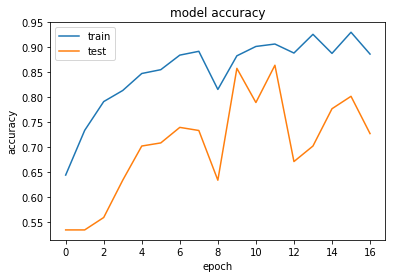

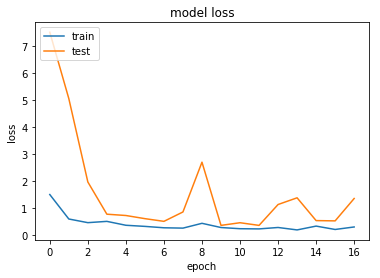

In [36]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [37]:
gmodel.load_weights(filepath=file_path)
score = gmodel.evaluate(X_valid, y_valid, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

161/161 [==============================] - 0s 1ms/step
Test loss: 0.354549808413
Test accuracy: 0.863354037267


#### test records: (Jan. 21, 2018)

161/161 [==============================] - 0s 2ms/step

Test loss: 0.405201216543
Test accuracy: 0.863354037267

161/161 [==============================] - 0s 2ms/step

Test loss: 0.240935826775
Test accuracy: 0.88198757764

161/161 [==============================] - 0s 2ms/step

Test loss: 0.401744958658
Test accuracy: 0.807453416149

161/161 [==============================] - 0s 2ms/step

Test loss: 0.473571754271
Test accuracy: 0.844720496894

#### (Feb. 7)
161/161 [==============================] - 0s 1ms/step batch 32, patient 5

Test loss: 0.354549808413
Test accuracy: 0.863354037267

### Future work for this section:
This result of this model fluctuate a lot. I fine tuned some of the parameters, but I haven't done that systematically. Actually, there are a bunch of parameters which can affect the result. Maybe building some gridsearch in a computer with a large RAM may work. But I decide only work on the basics.

The test loss I get from submitting into Kaggle LB is from 0.35 to 0.26.

<a id= "3.2"></a>
### 3.2 Convolutional neural network - with manually image rotation
Note: We observed high overfitting and "too good" val_accuracy = 100% when we use train_size = 0.9 in this section. So, we changed it to 0.7, which means more data will pass to the validation process.


In [38]:
X_train_rotate90 = np.concatenate([X_band_1_rotate90[:, :, :, np.newaxis], X_band_2_rotate90[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)
X_train_rotate180 = np.concatenate([X_band_1_rotate180[:, :, :, np.newaxis], X_band_2_rotate180[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)

X_train_rotate = np.concatenate([X_train, X_train_rotate90, X_train_rotate180],axis = 0)
target_train_rotate=np.concatenate([train['is_iceberg'],train['is_iceberg'],train['is_iceberg']],axis = 0)

In [40]:
X_train_cv_rotate, X_valid_rotate, y_train_cv_rotate, y_valid_rotate = train_test_split(X_train_rotate, target_train_rotate, random_state=1, train_size=0.7)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


#### Note: Shared value: X_train_cv_rotate, X_valid_rotate, y_train_cv_rotate, y_valid_rotate = train_test_split(X_train_rotate, target_train_rotate, random_state=1, train_size=0.7)

In [42]:
file_path_rotate = "model_weights_rotate.hdf5"
callbacks_rotate = get_callbacks(filepath=file_path_rotate, patience=5)
gmodel=getModel()
history_rotate = gmodel.fit(X_train_cv_rotate, y_train_cv_rotate,
          batch_size=32,
          epochs=30,
          verbose=1,
          validation_data=(X_valid_rotate, y_valid_rotate),
          callbacks=callbacks_rotate)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 73, 73, 64)        1792      
_________________________________________________________________
batch_normalization_13 (Batc (None, 73, 73, 64)        256       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 71, 71, 64)        36928     
_________________________________________________________________
batch_normalization_14 (Batc (None, 71, 71, 64)        256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 33, 33, 64)        36928     
__________

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


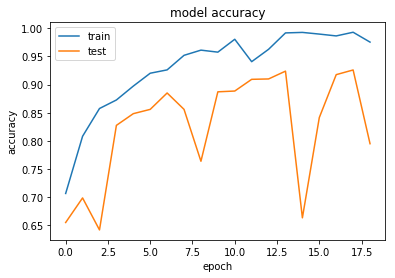

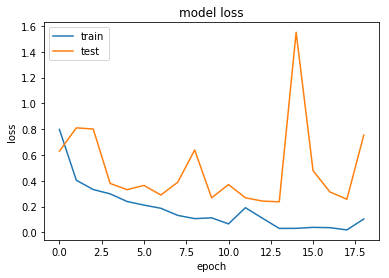

In [43]:
print(history_rotate.history.keys())
# summarize history for accuracy
plt.plot(history_rotate.history['acc'])
plt.plot(history_rotate.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_rotate.history['loss'])
plt.plot(history_rotate.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [44]:
gmodel.load_weights(filepath=file_path_rotate)
score = gmodel.evaluate(X_valid, y_valid, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

161/161 [==============================] - 0s 1ms/step
Test loss: 0.0836654507883
Test accuracy: 0.95652173913


#### Test records:
#### Jan. 21
1444/1444 [==============================] - 1s 996us/step

Test loss: 0.110237692046
Test accuracy: 0.985457063712

After changing the train_size from 0.9 to 0.7, the results is still "too good". Will not be as good when tested on new data from my experience.

1444/1444 [==============================] - 1s 913us/step

Test loss: 0.116922409504
Test accuracy: 0.979916897507

161/161 [==============================] - 0s 956us/step

Test loss: 0.353557794612
Test accuracy: 0.83850931677
#### Feb. 7
161/161 [==============================] - 0s 1ms/step

Test loss: 0.0836654507883
Test accuracy: 0.95652173913

### Future work
The result here is quite overfitting. 

The test loss I get from submitting into Kaggle LB is arround 0.22  (public 0.21 and private 0.23).

<a id= "3.3"></a>
### 3.3 Convolutional neural network - with ImageDataGenerator from Keras
ImageDataGenerator is the function built in the Keras library to do the image data argumentation, so we do not need to do it manually so I did to rotate the image 90 degree and 180 degree.

Let's see how it works. We will use the dataset without rotated images.

In [47]:
from keras.preprocessing.image import ImageDataGenerator
file_path_img_gen = "model_weights_imageDataGenerator.hdf5"
callbacks_img_gen = get_callbacks(filepath=file_path_img_gen, patience=5)

datagen = ImageDataGenerator(
                             rotation_range = 20,
                             width_shift_range = 0.1,
                             height_shift_range = 0.1,
                             zoom_range = 0.2)

#### Reference: the above datagen settings from: https://www.kaggle.com/c/statoil-iceberg-classifier-challenge/discussion/45265#261232

In [48]:
gmodel=getModel()
gmodel.fit_generator(datagen.flow(X_train_cv, y_train_cv, batch_size=24),
                     
                    steps_per_epoch=len(X_train_cv) / 24, 
                     
                    epochs=30,
                    validation_data=(X_valid, y_valid),
                    validation_steps=len(X_valid) / 24,
                    callbacks=callbacks_img_gen)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 73, 73, 64)        1792      
_________________________________________________________________
batch_normalization_17 (Batc (None, 73, 73, 64)        256       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 71, 71, 64)        36928     
_________________________________________________________________
batch_normalization_18 (Batc (None, 71, 71, 64)        256       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 33, 33, 64)        36928     
__________

In [49]:
gmodel.load_weights(filepath=file_path_img_gen)
score = gmodel.evaluate(X_valid, y_valid, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

161/161 [==============================] - 0s 1ms/step
Test loss: 0.296902897076
Test accuracy: 0.875776397516


#### Test records:
161/161 [==============================] - 0s 1ms/step

Test loss: 0.220500707626
Test accuracy: 0.900621118012

1444/1444 [==============================] - 1s 913us/step

Test loss: 0.427081537049
Test accuracy: 0.799861495845

#### Feb. 7
161/161 [==============================] - 0s 1ms/step

Test loss: 0.296902897076
Test accuracy: 0.875776397516

<a id= "3.4"></a>
### 3.4 Convolutional neural network - with cross validation
Cross validation (cv) is important when we do not have enough training data, because it use all the training data. Also, it help to decreas overfitiing, so the model will work well on predicting results of new testing data.

There are several ways to use cv. First, we can use cv to validate if the set of hyperparameter is better from another. By using cv, we can more confidentially say one set is better than the other since cv can get a statistic aspect and avoid judging the flutuating results from different initializations. Second, we can use cv to generate different sets of predicted results and average them (bagging ensemble ?) to get a better overall score.

Here is a good example of code writen by Jirka using the second kind of cv: [link](https://www.kaggle.com/jirivrany/my-best-single-model-simple-cnn-lb-0-1541). I trained this model with some minor changes and get my best score around 0.16.

<a id= "3.5"></a>
### 3.5 Random forest - feature generated from a convolutional neural network
Convnet may be a good feature finder for a tree model, since it scan the image patch by patch. It may get some feature in that patch, not a single pixel, which may contain too much noise. We load the weight trained in section 3.1 of this notebook and use the weights of layers upto the flatten layer.

In [51]:
def getModel_rf():
    
    gmodel=Sequential()
    
    #Conv Layer 1
    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
    gmodel.add(BatchNormalization())
    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu'))
    gmodel.add(BatchNormalization())
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.4))

    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu'))
    gmodel.add(BatchNormalization())
    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu'))
    gmodel.add(BatchNormalization())
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.4))
    
    #Flatten the data for upcoming dense layers
    gmodel.add(Flatten())

    gmodel.summary()
    return gmodel

In [52]:
gmodel=getModel_rf()
gmodel.load_weights('model_weights.hdf5',by_name=True)
rf_gen = gmodel.predict(X_train)

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=500, oob_score=True)
rf = rf.fit(rf_gen, target_train)
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 73, 73, 64)        1792      
_________________________________________________________________
batch_normalization_21 (Batc (None, 73, 73, 64)        256       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 71, 71, 64)        36928     
_________________________________________________________________
batch_normalization_22 (Batc (None, 71, 71, 64)        256       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 33, 33, 64)        36928     
__________

#### Test record:
Our OOB prediction of accuracy is: 79.30174563591022%
#### Feb. 7
Our OOB prediction of accuracy is: 79.98753117206982%

#### Conclusions: 
This is just a fast prototyping of this method. It have a lot of room to improve, but less likely as good as the Convnet models.


<a id= "3.6"></a>
### 3.6 Transfer learning - VGG16
Training a new Convnet can be time_consuming, and there are a lot of hyperparameters to be decided as well as the architecture of it. 

Transfer learning, which means using the already trained Convnet weights, and adjust it to solve this problem. This is useful because those pre-trained covnet contains features captures which maybe useful in this problem. VGG16 is a well known pre-trained convnet which won 2014 ImageNet challenge.

#### The following code is adapted from the offical tutorial:
[Building powerful image classification models using very little data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

In [53]:
from keras.applications.vgg19 import VGG19
from keras import applications
def train_top_model(input_shape):
    
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    mypotim=Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=mypotim,
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    #model.summary()
    return model

In [54]:
file_path_VGG16 = 'top_model_weights_path.h5'
callbacks_VGG16 = get_callbacks(file_path_VGG16,patience=10)

VGGmodel = applications.VGG16(include_top=False, weights='imagenet')

X_train_VGG16 = VGGmodel.predict(X_train_cv)
X_valid_VGG16 = VGGmodel.predict(X_valid)

input_shape=X_train_VGG16.shape[1:]

In [55]:
model = train_top_model(input_shape)

model.fit(X_train_VGG16, y_train_cv,
          epochs=30,
          batch_size=24,
          verbose=1,
          validation_data=(X_valid_VGG16, y_valid),
          callbacks=callbacks_VGG16)

model.load_weights(filepath=file_path_VGG16)
                
scores = model.evaluate(X_valid_VGG16, y_valid, verbose=1)

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Train on 1443 samples, validate on 161 samples
Epoch 1/30
1443/1443 [==============================] - 2s 1ms/step - loss: 0.8423 - acc: 0.5897 - val_loss: 0.5043 - val_acc: 0.7453
Epoch 2/30
1443/1443 [==============================] - 1s 386us/step - loss: 0.5531 - acc: 0.7082 - val_loss: 0.4336 - val_acc: 0.7764
Epoch 3/30
1443/1443 [==============================] - 1s 380us/step - loss: 0.5116 - acc: 0.7270 - val_loss: 0.4169 - val_acc: 0.7950
Epoch 4/30
1443/1443 [==============================] - 1s 382us/step - loss: 0.4756 - acc: 0.7574 - val_loss: 0.3884 - val_acc: 0.7764
Epoch 5/30
1443/1443 [==============================] - 1s 374us/step - loss: 0.4325 - acc: 0.7741 - val_loss: 0.3879 - val_acc: 0.8075
Epoch 6/30
1443/1443 [==============================] - 0s 308us/step - loss: 0.4066 - acc: 0.7900 - val_loss: 0.3933 - val_acc: 0.8075
Epoch 7/30
1443/1443 [==============================] - 0s 303us/step - loss: 0.3924 - acc: 0.8087 - val_loss: 0.3884 - val_acc: 0.8075
Epo

### Then fine-tuning the last section of the VGG

In [56]:
def model_plus():
    
    base_model = applications.VGG16(weights='imagenet', include_top=False,input_shape=(75,75,3))
    # build a classifier model to put on top of the convolutional model
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(1024, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))
    
    # note that it is necessary to start with a fully-trained
    # classifier, including the top classifier,
    # in order to successfully do fine-tuning
    
    
    top_model.load_weights(file_path_VGG16)
    # add the model on top of the convolutional base
    #model.add(top_model)
    
    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
    # set the first 25 layers (up to the last conv block)
    # to non-trainable (weights will not be updated)
    
    
    for layer in model.layers[:-5]:
        layer.trainable = False
    # compile the model with a SGD/momentum optimizer
    # and a very slow learning rate.
    
    
    mypotim=Adam(lr=1e-6, beta_1=0.7, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='binary_crossentropy',
                  optimizer=mypotim,
                  metrics=['accuracy'])
    return model

In [57]:
file_path_VGG16_finetuning = "model_weights_VGG16_finetuning.hdf5"
callbacks_VGG16_finetuning = get_callbacks(file_path_VGG16_finetuning, 5)
model = model_plus()
history = model.fit(X_train_cv, y_train_cv,
          epochs=30,
          batch_size=24,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks = callbacks_VGG16_finetuning)

model.load_weights(filepath=file_path_VGG16_finetuning)
    
scores = model.evaluate(X_valid, y_valid, verbose=1)

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Train on 1443 samples, validate on 161 samples
Epoch 1/30
1443/1443 [==============================] - 9s 6ms/step - loss: 0.2972 - acc: 0.8649 - val_loss: 0.3618 - val_acc: 0.8385
Epoch 2/30
1443/1443 [==============================] - 6s 4ms/step - loss: 0.2862 - acc: 0.8593 - val_loss: 0.3482 - val_acc: 0.8447
Epoch 3/30
1443/1443 [==============================] - 5s 3ms/step - loss: 0.2811 - acc: 0.8725 - val_loss: 0.3490 - val_acc: 0.8447
Epoch 4/30
1443/1443 [==============================] - 5s 3ms/step - loss: 0.2855 - acc: 0.8725 - val_loss: 0.3557 - val_acc: 0.8385
Epoch 5/30
1443/1443 [==============================] - 5s 3ms/step - loss: 0.2605 - acc: 0.8822 - val_loss: 0.3581 - val_acc: 0.8323
Epoch 6/30
1443/1443 [==============================] - 5s 3ms/step - loss: 0.2547 - acc: 0.8801 - val_loss: 0.3548 - val_acc: 0.8323
Epoch 7/30
161/161 [==============================] - 0s 2ms/step
Test loss: 0.34817296488
Test accuracy: 0.844720496894


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


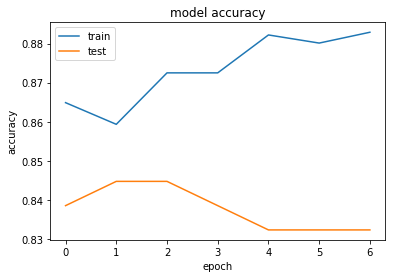

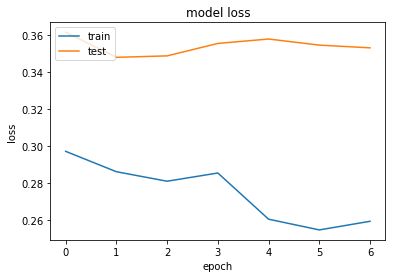

In [58]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Test records:
Test loss: 0.333277187441
Test accuracy: 0.83850931677

#### Feb. 7th
Test loss: 0.34817296488
Test accuracy: 0.844720496894

### Final notes:
This is my very first data science project, and I made tons of mistakes in the process and still making now. Training several different models can be time-consuming as well. Although I didn't get the ideal score at the end of the competition, I gained experience and I was exposed to so many concepts that was new to me. 

In a next kaggle project, I want to build a more stable model, put CV in the model training for sure, and try some ensemble methods. 
